## Web-scraping of *Departmental Working Papers of Economics, Roma Tre University*

#### Reqruired libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from requests import get
from bs4 import BeautifulSoup as bs
from random import randint
from time import sleep
from timeit import default_timer as timer
from datetime import timedelta
from urllib.request import Request, urlopen
from fake_useragent import UserAgent
import random
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### Retrieve data from IDEAS

In [ ]:
# Retrieve the number of pages

url = 'https://ideas.repec.org/s/rtr/wpaper.html'

response = get(url)

html_soup = bs(response.text, 'html.parser')

containers = html_soup.find_all('a', class_ = 'page-link')

pages = []

for container in containers:
    pages.append(container.text)
    
x = [s for s in pages if s != "«" and s != "»" and s != "1"]

x = list(dict.fromkeys(x))

y = ['']

pages = y + x

In [ ]:
# Retrieve paper name, authors, and year of publication

year_list = []
title_list = []
author_list = []

for page in pages:
    
    sleep(randint(1,3))
    
    url = 'https://ideas.repec.org/s/rtr/wpaper' + page + '.html'
    
    response = get(url)
    
    soup = bs(response.text, 'html.parser')
    
    container = soup.select_one("#content")
    
    year_list.extend([int(h.text) for h in container.find_all('h3')])
    
    for panel in container.select("div.panel-body"):
        
        title_list.append([x.text for x in panel.find_all('a')])
    
        author_list.append([x.next_sibling.strip() for x in panel.find_all('i')])

In [ ]:
# Generate a unique dataframe

df_title = pd.DataFrame(title_list) 
df_author = pd.DataFrame(author_list)
df_year = pd.DataFrame(year_list)
df_year = df_year.rename(columns = {0: 'year'})

df_year_author = pd.concat([df_year, df_author.reindex(df_year.index)], axis = 1)

dup_year_1 = df_year_author[df_year_author['year'].duplicated(keep = 'last')]
dup_year_1.dropna(axis = 1, how = 'all', inplace = True)
dup_year_2 = df_year_author[df_year_author['year'].duplicated(keep = 'first')]
dup_year_2.dropna(axis = 1, how = 'all', inplace = True)

dup_year_conc = pd.merge(dup_year_1, dup_year_2, how = 'outer', on = ['year'])
dup_year_conc_y = dup_year_conc['year']
dup_year_conc = dup_year_conc.loc[:, dup_year_conc.columns != 'year']
dup_year_conc.columns = range(dup_year_conc.shape[1])

dup_year = pd.concat([dup_year_conc_y,dup_year_conc], axis = 1)
df_year_author_no_dup = df_year_author.drop_duplicates(subset = 'year', keep = False) 

df_year_author = df_year_author_no_dup.append(dup_year)
df_year_author = df_year_author.sort_values(['year'], ascending = [False])
df_year_author = df_year_author.add_prefix('col_')
df_year_author = df_year_author.rename(columns = {'col_year': 'year_pub'})
df_year_author = df_year_author.reset_index()

df_year_title = pd.concat([df_year, df_title.reindex(df_year.index)], axis = 1)

dup_year_1 = df_year_title[df_year_title['year'].duplicated(keep = 'last')]
dup_year_1.dropna(axis = 1, how = 'all', inplace = True)
dup_year_2 = df_year_title[df_year_title['year'].duplicated(keep = 'first')]
dup_year_2.dropna(axis = 1, how = 'all', inplace = True)

dup_year_conc = pd.merge(dup_year_1, dup_year_2, how = 'outer', on = ['year'])
dup_year_conc_y = dup_year_conc['year']
dup_year_conc = dup_year_conc.loc[:, dup_year_conc.columns != 'year']
dup_year_conc.columns = range(dup_year_conc.shape[1])

dup_year = pd.concat([dup_year_conc_y,dup_year_conc], axis = 1)
df_year_title_no_dup = df_year_title.drop_duplicates(subset = 'year', keep = False) 

df_year_title = df_year_title_no_dup.append(dup_year)
df_year_title = df_year_title.sort_values(['year'], ascending = [False])
df_year_title = df_year_title.add_prefix('col_')
df_year_title = df_year_title.rename(columns = {'col_year': 'year_pub'})
df_year_title = df_year_title.reset_index()

df_author = pd.wide_to_long(df_year_author, stubnames = 'col_', i = 'year_pub', j = 'ord_pub')
df_author = df_author.rename(columns = {'col_': 'author'})
df_author = df_author.drop(['index'], axis = 1)

df_title = pd.wide_to_long(df_year_title, stubnames = 'col_', i = 'year_pub', j = 'ord_pub')
df_title = df_title.rename(columns = {'col_': 'title'})
df_title = df_title.drop(['index'], axis = 1)

df = pd.concat([df_title, df_author.reindex(df_title.index)], axis = 1)
df = df.sort_values(['year_pub'], ascending = [False])
df = df.reset_index()
df = df.dropna()

In [ ]:
# Split data frames by years

grouped_years = df.groupby(df.year_pub)

for year in year_list:
    globals()['df_' + str(year)] = grouped_years.get_group(year)

#### Dynamic IP and Request

In [ ]:
# The following commands have been retrieved from the following sources: 
# - https://codelike.pro/create-a-crawler-with-rotating-ip-proxy-in-python/
# - https://stackoverflow.com/questions/38785877/spoofing-ip-address-when-web-scraping-python

In [3]:
# Retrieve a list of proxies
ua = UserAgent() # it will generate a random user agent
proxies = [] # it will contain proxies [ip, port]

# Main function
def main():
  # Retrieve latest proxies
  proxies_req = Request('https://www.sslproxies.org/')
  proxies_req.add_header('User-Agent', ua.random)
  proxies_doc = urlopen(proxies_req).read().decode('utf8')

  soup = bs(proxies_doc, 'html.parser')
  proxies_table = soup.find(id='proxylisttable')

  # Save proxies in the array
  for row in proxies_table.tbody.find_all('tr'):
    proxies.append({
      'ip':   row.find_all('td')[0].string,
      'port': row.find_all('td')[1].string
    })

  # Choose a random proxy
  proxy_index = random_proxy()
  proxy = proxies[proxy_index]

  # Perform 50 requests
  for n in range(1, 50):
    req = Request('http://icanhazip.com')
    req.set_proxy(proxy['ip'] + ':' + proxy['port'], 'http')

    # Every 10 requests, generate a new proxy
    if n % 10 == 0:
      proxy_index = random_proxy()
      proxy = proxies[proxy_index]

    # Make the call
    try:
      my_ip = urlopen(req).read().decode('utf8')
      print('#' + str(n) + ': ' + my_ip)
      clear_output(wait = True)
    except: # If error, delete this proxy and find another one
      del proxies[proxy_index]
      print('Proxy ' + proxy['ip'] + ':' + proxy['port'] + ' deleted.')
      proxy_index = random_proxy()
      proxy = proxies[proxy_index]

# Retrieve a random index proxy
def random_proxy():
  return random.randint(0, len(proxies) - 1)

if __name__ == '__main__':
  main()

#49: 128.199.251.249



In [ ]:
# The following command has been retrieved from the following source:
# - https://www.scrapehero.com/how-to-fake-and-rotate-user-agents-using-python-3/

# List of user agents
user_agent_list = (
    #Chrome
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (Windows NT 5.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
    #Firefox
    'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
    'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.1; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 6.2; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64; Trident/7.0; rv:11.0) like Gecko',
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)',
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)',
    'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 2.0.50727; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729)'
)

#### Extract citations from Google Scholar

In [ ]:
# Note:
# In order to avoid the bann from Google, you can use random user agent and proxy
# Moreover, you can also change your IP (e.g. by using Hide.me: https://hide.me/en/)
# A wise choice is to make the process 'slow'

start = timer()

title_list_gs = []
citations_list_gs = []
link_list = []

for year in year_list:
    
    globals()['df_' + str(year)]['titles_authors'] = globals()['df_' + str(year)]['title'] + ' ' + globals()['df_' + str(year)]['author']
    titles_authors = globals()['df_' + str(year)]['titles_authors'].to_list()

    # Print results
    print('\n', year)    
    
    title_list_gs2 = []
    citations_list_gs2 = []
    link_list2 = []
        
    with requests.Session() as s:
        
        for title in titles_authors: 
            
            sleep(randint(60, 120)) # Run a query every x-y seconds
            
            user_agent = random.choice(user_agent_list)
            headers= {'User-Agent': user_agent, "Accept-Language": "en-US, en;q=0.5"}
            #proxy = random.choice(proxies) # Comment out to use random proxies
                
            url = 'https://scholar.google.com/scholar?q=' + title + '&ie=UTF-8&oe=UTF-8&hl=en&btnG=Search'

            r = s.get(url, headers = headers)
            #r = s.get(url, headers = headers, proxies = proxy) # Comment out to use random proxies
            soup = bs(r.content, 'html.parser')
            
            # Retrieve title
            title_gs = soup.select_one('h3.gs_rt a').text if soup.select_one('h3.gs_rt a') is not None else 'No title'
            title_list_gs.append(title_gs)
            title_list_gs2.append(title_gs)
            
            # Retrieve number of citations
            citations_gs = soup.select_one('a:contains("Cited by")').text if soup.select_one('a:contains("Cited by")') is not None else 'No citation count'
            citations_list_gs.append(citations_gs)
            citations_list_gs2.append(citations_gs)

            # Retrieve link
            link_gs = soup.select_one('h3.gs_rt a')['href'] if title != 'No title' else 'No link'
            link_list.append(link_gs)
            link_list2.append(link_gs)
            
            print('Title:', title_gs, '; Citations:', citations_gs) 
            
    globals()['df_' + str(year)]['citations'] = np.array(citations_list_gs2) 
    globals()['df_' + str(year)]['citations'] = globals()['df_' + str(year)]['citations'].str.extract('(\d+)').astype(float) 
    globals()['df_' + str(year)]['link'] = np.array(link_list2)
    
# Required time
end = timer()
print('\n Retrieve data from from Google Scholar')
print('- required time:') 
print(timedelta(seconds = end - start))

In [ ]:
# Merge all sub data frames

df_names = []

for year in year_list:
    df_names.append('df_' + str(year))

df_list = []

for df_ in df_names:
    df_list.append(locals()[df_])
    
df_all = pd.concat(df_list)

# Flag weird results (e.g. elevated citations, greater than 100)
# Better to check manually those cases
def flagcit(x):
    if x >= 100:
        return 1
    else:
        return None
    
df_all['flag'] = df_all['citations'].apply(flagcit)

# Eliminate possible outliers: drop citations greater than 500
def erasecit(x):
    if x >= 500:
        return None
    else:
        return x
    
df_all['citations'] = df_all['citations'].apply(erasecit)

# Save the data frame as .csv
df_all.to_csv('C:/Users/Nicola Caravaggio/OneDrive/Desktop/rm3_web_scraping.csv', index = False)  

#### Plot results

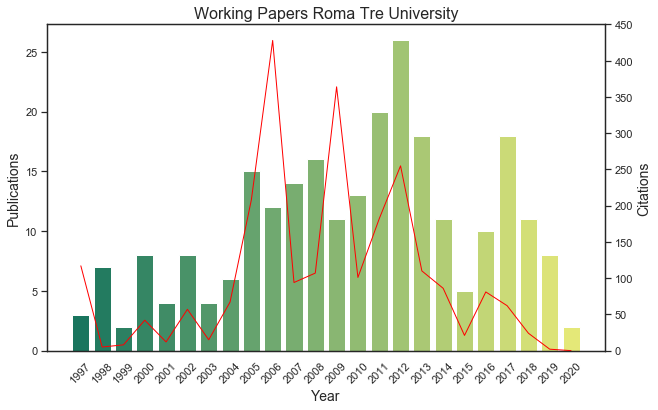

In [3]:
# Here the data already extracted
url = 'https://raw.githubusercontent.com/nicolacaravaggio/working_paper_roma3/master/rm3_working_paper_list_cit.csv'
df_all = pd.read_csv(url, error_bad_lines = False)

# Rearrange data
df_count = df_all.groupby(['year_pub']).count()
df_count = df_count.reset_index()
df_count['year_pub'] = df_count['year_pub'].astype(str)

df_sum = df_all.groupby(['year_pub']).sum()
df_sum = df_sum.reset_index()
df_sum['year_pub'] = df_sum['year_pub'].astype(str)

sns.set(style = "white", rc = {"lines.linewidth": 1})

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Working Papers Roma Tre University', fontsize=16)

# Bar plot creation
ax1 = sns.barplot(x = 'year_pub', 
                  y = 'title', 
                  data = df_count, 
                  palette = 'summer')

ax1.set_xlabel('Year', 
               fontsize = 14)
ax1.set_ylabel('Publications', 
               fontsize = 14)
ax1.tick_params(axis = 'y')

# Mirror results
ax2 = ax1.twinx()

# Line plot creation
ax2 = sns.lineplot(x = 'year_pub', 
                   y = 'citations', 
                   data = df_sum, 
                   sort = False, 
                   color = 'red')
ax2.set_ylim([0, 450])
ax2.set_ylabel('Citations', 
               fontsize = 14)
ax2.tick_params(axis = 'y')

ax1.tick_params('x', labelrotation = 45)

# Save plot
#plt.savefig('C:/Users/Nicola Caravaggio/OneDrive/Desktop/working_paper_roma3.png')
# Show plot
plt.show()

#### Descriptive statistics

In [11]:
# Convert years from string to int
df_all['year_pub'] = df_all['year_pub'].astype(int)
df_count['year_pub'] = df_count['year_pub'].astype(int)
df_sum['year_pub'] = df_sum['year_pub'].astype(int)

# Total number of published Working Papers
print('Total number of published Working Papers:', df_all['title'].count())

# Average number of Working Papers per year
print('Average number of Working Papers per year:', df_count['title'].mean())

# Most flourishing year
df_max = df_count.sort_values('title', ascending = False)
print('Most flourishing year:', df_max.iloc[0]['year_pub'], 'with', max(df_max['title']), 'published papers')

# Least flourishing year (excluding first and last years)
df_min = df_count.sort_values('title', ascending = True)
df_min = df_min.loc[~((df_min['year_pub'] == max(df_min['year_pub'])) | (df_min['year_pub'] == min(df_min['year_pub']))),:]
print('Least flourishing year (excluding first and last years):', df_min.iloc[0]['year_pub'], 'with', min(df_min['title']), 'published papers')

# Year with the most cited papers
df_cit_max = df_sum.sort_values('citations', ascending = False)
print('Year with the most cited papers:', df_cit_max.iloc[0]['year_pub'].astype(int), 'with', df_cit_max.iloc[0]['citations'].astype(int), 'citations')

# Top 10 Working Papers by citations
print('Top 10 Working Papers by citations:')
top_10 = (df_all.sort_values('citations', ascending = False)).head(10)
top_10 = top_10[['title','author','year_pub','citations']]
top_10['citations'] = top_10['citations'].astype(int)
blankIndex=[''] * len(top_10)
top_10.index = blankIndex
top_10

Total number of published Working Papers: 252
Average number of Working Papers per year: 10.5
Most flourishing year: 2012 with 26 published papers
Least flourishing year (excluding first and last years): 1999 with 2 published papers
Year with the most cited papers: 2006 with 428 citations
Top 10 Working Papers by citations:


,title,author,year_pub,citations
,The causality between energy consumption and e...,Valeria Costantini & Chiara Martini,2009,315
,"Environment, human development and economic gr...",Valeria Costantini & Salvatore Monni,2006,263
,Accomulation of capital,Pierangelo Garegnani & Antonella Palumbo,1997,105
,"Financial Liberalization, Bank Crises and Grow...",Alessandra Bonfiglioli & Caterina Mendicino,2005,105
,How are We doing on Poverty and Hunger Reducti...,Ugo Gentilini,2006,70
,Corruption and the effects of economic freedom,Luca Pieroni & Giorgio D'Agostino,2011,63
,The impact of the economic crisis on the EU la...,Pasquale Tridico,2012,62
,"Credit Frictions, housing prices and optimal m...",Caterina Mendicino & Andrea Pescatori,2004,62
,The diffusion of broadband telecommunications:...,Mario Denni & Harald Gruber,2006,55
,Spatial Discontinuity for the Impact Assessmen...,Mara Giua,2014,48
